In [160]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft
from scipy.linalg import toeplitz
import pandas as pd

Question 1

(a)

From the lecture notes, we know that the spectral densities for $MA(q)$, $AR(p)$ and $ARMA(p,q)$ processes are 
\begin{align*}
S_{MA}(f) &= \sigma_{\varepsilon}^2 |1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2\\
S_{AR}(f) &= \frac{\sigma_{\varepsilon}^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}\\
S_{ARMA}(f) &= \sigma_{\varepsilon}^2\frac{|1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}.
\end{align*}
Note that the third formula can be used for all cases in our function. So if we have an $MA(q)$ process, then in our function the phis list will be empty and the denominator will be $|1|^2 = 1$ resulting in the formula for the $S_{MA}(f)$.
Below, for each element in f we first calculate the transfer functions $G_{\phi}(f[i])$ and $G_{\theta}(f[i])$ and then we determine the sdf evaluated at $f[i]$.

In [161]:
def S_ARMA(f, phis, thetas, sigma2):
    """Input: 
    f: list of frequences at which it should be evaluated (must be in the interval [1/2, 1/2))
    phis: the list [phi_{1,p},..., phi_{p,p}]
    thetas: the list [theta_{1,q},..., theta_{q,q}]
    sigma2: a scalar for the variance of the white noise
    Output:
    S: theoretical spectral density function for a ARMA(p,q) process evaluated for each element in f."""

    # find p and q
    p = len(phis)
    q = len(thetas)

    # initialize sdf to be zero everywhere
    S = np.zeros(len(f))
    
    # for each element in f, evaluate the sdf
    for i in range(len(f)):            
        # initialize the two sums
        G_theta = 1
        G_phi = 1

        # G_phi = (1 - phi_1*exp(-i*2*pi*f*1) - ... - phi_p*exp(-i*2*pi*f*p))
        for m in range(p):
            G_phi = G_phi - phis[m]*np.e**(-1j*2*np.pi*f[i]*(m+1))
        
        # G_theta = (1 - theta_1*exp(-i*2*pi*f*1) - ... - theta_q*exp(-i*2*pi*f*q))
        for n in range(q):
            G_theta = G_theta - thetas[n]*np.e**(-1j*2*np.pi*f[i]*(n+1))

        # update the ith element of S
        S[i] = sigma2*(abs(G_theta))**2/(abs(G_phi))**2
 
    return S

(b)

We now simulate a Gaussian $ARMA(2,2)$ process of length $N$ given by
\begin{equation*}
X_t = \phi_{1,2}X_{t-1} + \phi_{2,2}X_{t-2} + \epsilon_t - \theta_{1,2}\epsilon_{t-1} - \theta_{2,2}\epsilon_{t-2}, \quad t>2.
\end{equation*}

In [162]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """Input:
    phis: the list [phi_{1,2}, phi_{2,2}]
    thetas: the list [theta_{1,2}, theta_{2,2}]
    sigma2: a scalar for the variance of the white noise
    N: length of simulated process
    Output: 
    Time series of length N simulated by the ARMA(2,2) process."""
    
    # initialize list recording the values of the stochastic process
    X = np.zeros(N+100)

    # create an array with N + 100 epsilons following normal distribution with mean 0 and variance sigma2
    epsilons = np.random.normal(0,np.sqrt(sigma2), N+100)

    # recursively update the values Xt
    for i in range(2,N+100):
        X[i] = phis[0]*X[i-1] + phis[1]*X[i-2] + epsilons[i] - thetas[0]*epsilons[i-1] - thetas[1]*epsilons[i-2]
        
    # return an array with only the N values after the first 100
    return X[-N:]

(c)

The Fast Fourier Transform algorithm $fft(X)$ takes our $N$ dimensional time series and outputs an $N$ dimensional list $y$, where
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} X[k] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
This is similar to the fourier transform we need for computing the periodogram, which is given by
\begin{equation*}
\sum_{t = 1}^{N} X_t e^{-i2\pi f_k t}.
\end{equation*}
Noting that python counts from 0 instead of 1, we can transform this into 
\begin{equation*}
\sum_{t = 0}^{N-1} X[t] e^{-i2\pi f_k (t+1)} = y[k]e^{-i 2\pi f_k},
\end{equation*}
i.e., after obtaining the $y[k]$ using the fft method, we need to multiply each element by $e^{-i 2\pi f_k}$. Our estimate of the sdf is then
\begin{equation*}
S[k] = \frac{1}{N} \big| y[k]e^{-i 2\pi f_k} \big|^2 = \frac{1}{N} \big| fft(X) e^{-i 2\pi f_k} \big|^2
\end{equation*}

We have obtained our estimate for the sdf for the Fourier frequencies $f_k$ which range from $0$ to $(N-1)/N$. We note that in the lectures notes we define the periodogram over $[-1/2, 1/2)$. Using the fact that the sdf is periodic, we can obtain $\hat{S}^p(f_k)$ by using $fftshift$, i.e. rearranging the frequencies so that the N Fourier frequencies lie in the interval $[-1/2, 1/2)$. This will be done later when creating plots.

In [163]:
def periodogram(X):
    """Input:
    X: numpy array of the time series
    Output:
    The periodogram at the Fourier frequencies for X."""
    
    N = len(X)

    # Fourier frequencies
    f_k = np.arange(0,N)/N
    
    # compute the periodogram using the method described above
    S = abs(fft(X)*(np.exp(-1j*2*np.pi*f_k)))**2/N

    return S

We now compute the direct spectrail estimate at the Fourier frequencies using a $p \times 100 \%$ cosine taper. We use the taper from the lecture notes (with slight adaptation since python counts from 0).

We want to calculate 
\begin{equation*}
\sum_{t = 1}^N h_tX_te^{i2\pi f t} \quad \text{or since python counts from 0} \quad \sum_{t = 0}^{N-1} h[t]X[t]e^{i2\pi f_k (t+1)}
\end{equation*}
Once again, since the $fft$ algorithm computes
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} h[n]X[n] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
So we need to multiply by $e^{-i2 \pi f_k}$:
\begin{equation*}
\sum_{t = 0}^{N-1} h[t]X[t]e^{i2\pi f_k (t+1)} = y[k] e^{-i2 \pi f_k}
\end{equation*}
Now we can compute the direct spectral estimator
\begin{equation*}
S[k] = \big| y[k] e^{-i2 \pi f_k} \big|^2 = \big| fft(h X) e^{-i2 \pi f_k} \big|^2
\end{equation*}
Once again, we note that we have obtained the direct spectral estimate over the domain $[0,1)$. Later when plotting we will need to use the fftshift function so that the domain is $[-1/2, 1/2)$ as defined in the lecture notes.

In [164]:
def direct(X,p):
    """
    Input:
    X: time series
    p: variable for cosine taper
    Output:
    Direct spectral estimate at the Fourier frequencies using px100% cosine taper for X."""
    
    N = len(X)

    interval = np.arange(0,N)  # range of the taper

    # create the three intervals for the taper
    interval1 = interval[0:int(np.floor(p*(N))/2)]
    interval2 = interval[int(np.floor(p*(N))/2): N - int(np.floor(p*N)/2)]
    interval3 = interval[N - int(np.floor(p*N)/2): ]

    # for each interval set the value of h
    h1 = 0.5*(1- np.cos(2*np.pi*(interval1+1)/(np.floor(p*N)+1)))
    h2 = np.ones(interval2.shape)
    h3 = 0.5*(1 - np.cos(2*np.pi*(N - interval3)/(np.floor(p*N)+1)))
    h = np.concatenate((h1, h2, h3))

    # normalize so that the sum of h_t^2 = 1
    h = h/np.sqrt(np.sum(h**2))

    # Fourier frequencies
    f_k = interval/N

    # compute the directral spectral estimator as described above
    S = abs(fft(h*X)*(np.exp(-1j*2*np.pi*f_k)))**2

    return S

(d)

A.

We have that $r = 0.8$ and $f' = 12/128$. Using results from the lecture notes (page 51), we have that
\begin{equation*}
\phi_{1,2} = 2r \cos (2 \pi f') \quad \phi_{2,2} = -r^2.
\end{equation*}

We create a function that takes as an input $r$ and creates a matrix with $15$ rows and $10000$ columns. In each row we store the values of the $10000$ simulations for a certain frequency. For example in row $0$ we store the value of the periodogram at frequency $12/128$, at row $1$ the value of the periodogram at frequency $32/128$ and so on.

In [304]:
def frequencies(r):

    phi_1 = 2*r*np.cos(2*np.pi*12/128)
    phi_2 = -r**2

    matrix = np.empty(shape = (15, 10000))


    for i in range(10000):
        X = ARMA22_sim([phi_1, phi_2], [-0.5,-0.2], 1, 128)
        peri = periodogram(X)
        dir1 = direct(X, 0.05)
        dir2 = direct(X, 0.1)
        dir3 = direct(X, 0.25)
        dir4 = direct(X, 0.5)

        # frequencies for the periodogram 
        matrix[0][i] = peri[12]
        matrix[1][i] = peri[32]
        matrix[2][i] = peri[60]
        # frequencies for the direct spectral estimate with p = 0.05
        matrix[3][i] = dir1[12]
        matrix[4][i] = dir1[32]
        matrix[5][i] = dir1[60]
        # frequencies for the direct spectral estimate with p = 0.1
        matrix[6][i] = dir2[12]
        matrix[7][i] = dir2[32]
        matrix[8][i] = dir2[60]
        # frequencies for the direct spectral estimate with p = 0.25
        matrix[9][i] = dir3[12]
        matrix[10][i] = dir3[32]
        matrix[11][i] = dir3[60]
        # frequencies for the direct spectral estimate with p = 0.5
        matrix[12][i] = dir4[12]
        matrix[13][i] = dir4[32]
        matrix[14][i] = dir4[60]

    return matrix

B.

To compute the sample bias we need the true value of sdf at each of the three frequencies. We compute this by using our function S_ARMA from question 1. We then calculate the mean of each row of our matrix from above to calculate
\begin{equation*}
bias = E[\hat{\theta}] - \theta
\end{equation*}

In [321]:
# compute the true value at each frequency
true_12 = S_ARMA([12/128], [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1)
true_32 = S_ARMA([32/128], [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1)
true_60 = S_ARMA([60/128], [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1)

# compute bias for each frequency and each method
matrix = frequencies(0.8)
# for the periodogram
print("Sample bias of periodogram at 12/128: ", float(true_12 - np.mean(matrix[0])))
print("Sample bias of periodogram at 32/128: ", float(true_32 - np.mean(matrix[1])))
print("Sample bias of periodogram at 60/128: ", float(true_60 - np.mean(matrix[2])))
print("-"*80)
# for the direct spectral estimate with p = 0.05
print("Sample bias of direct spectral estimate (p = 0.05) at 12/128: ", float(true_12 - np.mean(matrix[3])))
print("Sample bias of direct spectral estimate (p = 0.05) at 12/128: ", float(true_32 - np.mean(matrix[4])))
print("Sample bias of direct spectral estimate (p = 0.05) at 12/128: ", float(true_60 - np.mean(matrix[5])))
print("-"*80)
# for the direct spectral estimate with p = 0.1
print("Sample bias of direct spectral estimate (p = 0.1) at 12/128: ", float(true_12 - np.mean(matrix[6])))
print("Sample bias of direct spectral estimate (p = 0.1) at 12/128: ", float(true_32 - np.mean(matrix[7])))
print("Sample bias of direct spectral estimate (p = 0.1) at 12/128: ", float(true_60 - np.mean(matrix[8])))
print("-"*80)
# for the direct spectral estimate with p = 0.25
print("Sample bias of direct spectral estimate (p = 0.25) at 12/128: ", float(true_12 - np.mean(matrix[9])))
print("Sample bias of direct spectral estimate (p = 0.25) at 12/128: ", float(true_32 - np.mean(matrix[10])))
print("Sample bias of direct spectral estimate (p = 0.25) at 12/128: ", float(true_60 - np.mean(matrix[11])))
print("-"*80)
# for the direct spectral estimate with p = 0.5
print("Sample bias of direct spectral estimate (p = 0.5) at 12/128: ", float(true_12 - np.mean(matrix[12])))
print("Sample bias of direct spectral estimate (p = 0.5) at 12/128: ", float(true_32 - np.mean(matrix[13])))
print("Sample bias of direct spectral estimate (p = 0.5) at 12/128: ", float(true_60 - np.mean(matrix[14])))


Sample bias of periodogram at 12/128:  0.9294770299412249
Sample bias of periodogram at 32/128:  -0.14240238107442388
Sample bias of periodogram at 60/128:  -0.05134623229132621
--------------------------------------------------------------------------------
Sample bias of direct spectral estimate (p = 0.05) at 12/128:  0.7137781489854618
Sample bias of direct spectral estimate (p = 0.05) at 12/128:  -0.05669229552024163
Sample bias of direct spectral estimate (p = 0.05) at 12/128:  -0.0005369944657834802
--------------------------------------------------------------------------------
Sample bias of direct spectral estimate (p = 0.1) at 12/128:  0.5928947856860773
Sample bias of direct spectral estimate (p = 0.1) at 12/128:  -0.025157772238259324
Sample bias of direct spectral estimate (p = 0.1) at 12/128:  -0.0002290228801086272
--------------------------------------------------------------------------------
Sample bias of direct spectral estimate (p = 0.25) at 12/128:  0.406430304089

In each of the 4 methods used we can see that the bias is largest for the frequency $12/128$ and smallest for $60/128$. Further, as we increase $p$ (the parameter of our taper) the bias redices significantly, so the direct spectral estimator with $p = 0.5$ gives the best estimates of the sdf at each of the frequencies.

C.



In [322]:
# store the true value at each frequency for each r 
true_12 = []
true_32 = []
true_60 = []
# store the value for each frequency estimated by the periodogram for each r
periodogram_12 = []
periodogram_32 = []
periodogram_60 = []
# store the value for each frequency estimated by direct spectral estimate with p = 0.05 for each r
direct1_12 = []
direct1_32 = []
direct1_60 = []
# store the value for each frequency estimated by direct spectral estimate with p = 0.1 for each r
direct2_12 = []
direct2_32 = []
direct2_60 = []
# store the value for each frequency estimated by direct spectral estimate with p = 0.25 for each r
direct3_12 = []
direct3_32 = []
direct3_60 = []
# store the value for each frequency estimated by direct spectral estimate with p = 0.5 for each r
direct4_12 = []
direct4_32 = []
direct4_60 = []


for r in np.arange(81,100)/100:
    # compute the true value at each frequency
    true_12.append(S_ARMA([12/128], [2*r*np.cos(2*np.pi*12/128), - r**2], [-0.5,-0.2], 1))
    true_32.append(S_ARMA([32/128], [2*r*np.cos(2*np.pi*12/128), - r**2], [-0.5,-0.2], 1))
    true_60.append(S_ARMA([60/128], [2*r*np.cos(2*np.pi*12/128), - r**2], [-0.5,-0.2], 1))
    # compute the matrix for different r
    matrix = frequencies(r)
    # append the appropriate values in each list
    periodogram_12.append(np.mean(matrix[0]))
    periodogram_32.append(np.mean(matrix[1]))
    periodogram_60.append(np.mean(matrix[2]))
    direct1_12.append(np.mean(matrix[3]))
    direct1_32.append(np.mean(matrix[4]))
    direct1_60.append(np.mean(matrix[5]))
    direct2_12.append(np.mean(matrix[6]))
    direct2_32.append(np.mean(matrix[7]))
    direct2_60.append(np.mean(matrix[8]))
    direct3_12.append(np.mean(matrix[9]))
    direct3_32.append(np.mean(matrix[10]))
    direct3_60.append(np.mean(matrix[11]))
    direct4_12.append(np.mean(matrix[12]))
    direct4_32.append(np.mean(matrix[13]))
    direct4_60.append(np.mean(matrix[14]))

D.

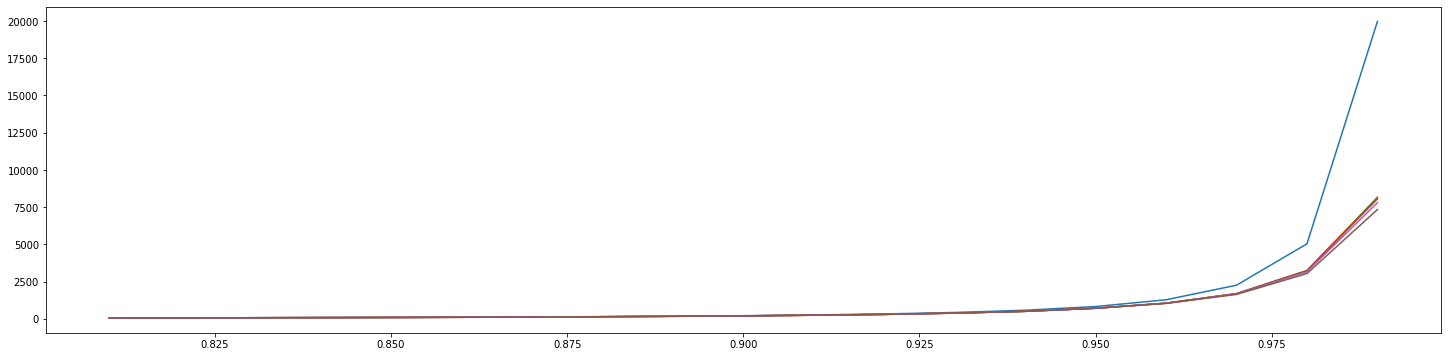

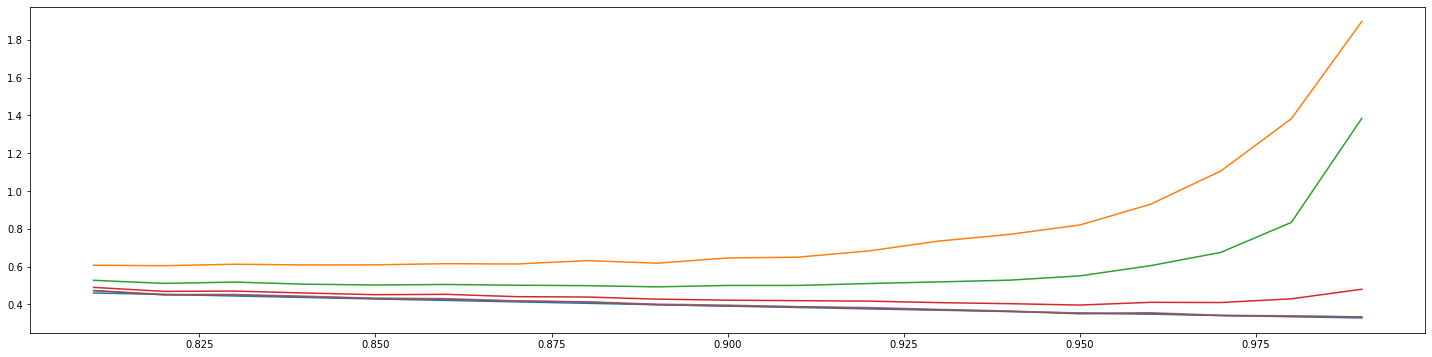

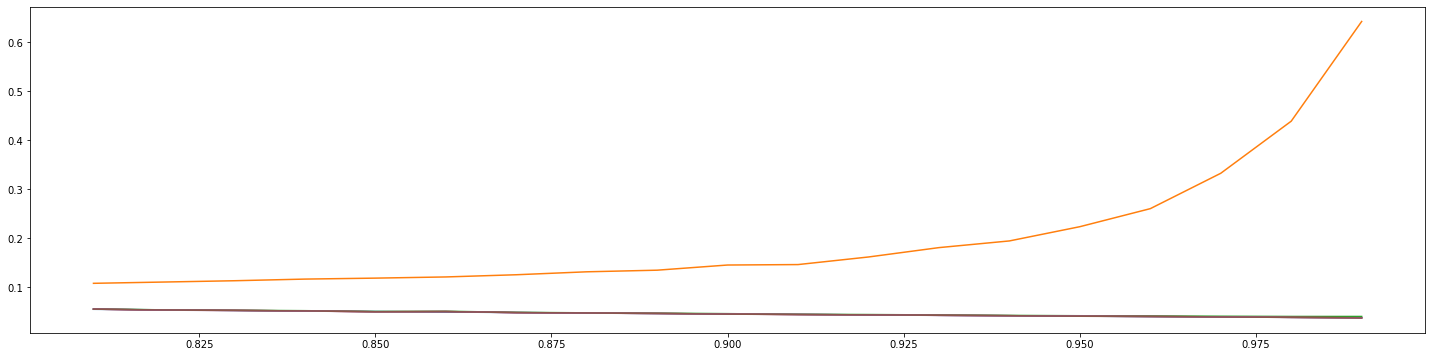

In [328]:
r = np.arange(81,100)/100
plt.figure(figsize=(25, 6))
plt.plot(r, true_12)
plt.plot(r, periodogram_12)
plt.plot(r, direct1_12)
plt.plot(r, direct2_12)
plt.plot(r, direct3_12)
plt.plot(r, direct4_12)
plt.show()

plt.figure(figsize=(25, 6))
plt.plot(r, true_32)
plt.plot(r, periodogram_32)
plt.plot(r, direct1_32)
plt.plot(r, direct2_32)
plt.plot(r, direct3_32)
plt.plot(r, direct4_32)
plt.show()

plt.figure(figsize=(25, 6))
plt.plot(r, true_60)
plt.plot(r, periodogram_60)
plt.plot(r, direct1_60)
plt.plot(r, direct2_60)
plt.plot(r, direct3_60)
plt.plot(r, direct4_60)
plt.show()

Question 2

(a)

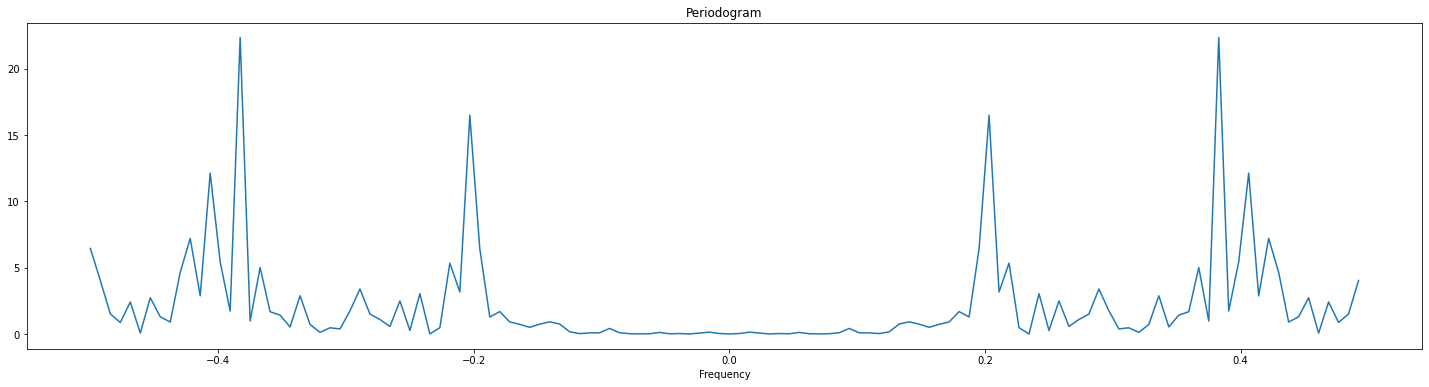

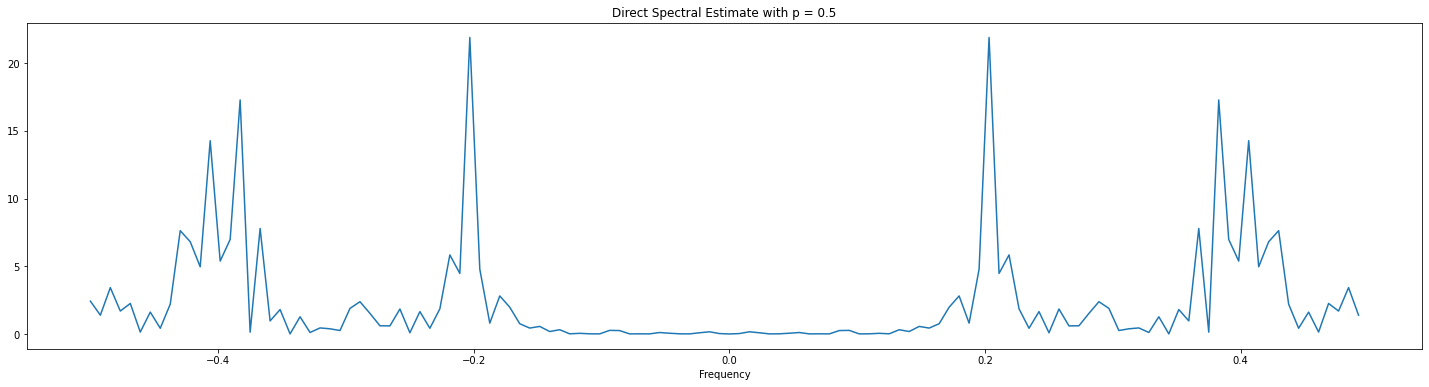

In [173]:
# read in the data
from numpy import genfromtxt
data = list(genfromtxt('88.csv', delimiter=','))

N = len(data)

# array over the range [-1/2, 1/2) with N values
t = np.arange(-N/2, N/2)/N

# plot the periodogram
plt.figure(figsize=(25, 6))
plt.plot(t, fftshift(periodogram(data)))  # we use fftshift so that the range is [-1/2, 1/2)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.show()

# plot the direct spectral estimate for p = 0.5
plt.figure(figsize=(25, 6))
plt.plot(t, fftshift(direct(data, p = 0.5)))
plt.title("Direct Spectral Estimate with p = 0.5")
plt.xlabel("Frequency")
plt.show()

(b)

First we create a function that fits an $AR(p)$ model using the untapered Yule-Walker method. Using the results derived in the lecture notes, we have that 
\begin{equation*}
\hat{\phi}_p = \hat{\Gamma}^{-1}\hat{\gamma}_p \quad \text{ and } \quad \hat{\sigma}^2_p = \hat{s}_0 - \sum_{j=1}^p \hat{\phi}_{i,p} \hat{s}_j,
\end{equation*}
where $\hat{\phi}_p = [\hat{\phi}_{1,p}, \dots, \hat{\phi}_{p,p}]^T$, $\hat{\gamma}_p = [\hat{s}_1, \dots, \hat{s}_p]^T$ and $\hat{\Gamma}_p$ is the Toeplitz matrix as descibed in the notes. We also have that
\begin{equation*}
\hat{s}_\tau = \frac{1}{N} \sum_{t=0}^{N - |\tau| - 1}X_t X_{t + |\tau|}
\end{equation*}
Below we first calculate $s_\tau$ for $\tau = 0, 1, ..., p$ and then find the estimates $\hat{\phi}_p$ and $\hat{\sigma}^2_p$. From these we can then compute the esimate of the sdf using our S_ARMA function from question 1.

In [174]:
def YW(X, p):
    """Input:
    X: Time series data.
    p: parameter of the AR(p) model we fit.
    Output:
    phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] for the AR(p) model
    sigma2: estimated variance of the white noise. """
    N = len(X)

    # initialize array that will contain s_0, s_1, ..., s_p
    s = np.zeros(p+1)

    for i in range(p+1):

        # calculate s_i
        for t in range(N-i):
            s[i] += X[t]*X[t+i]/N

    # construct the matrix Gamma and the vector gamma
    Gamma = toeplitz(s[0:p])
    gamma = s[1:]

    # calculate phis
    phis = np.dot(np.linalg.inv(Gamma), gamma)

    # compute the estimated variance
    sigma2 = s[0] - np.dot(phis, s[1:])
    
    return phis, sigma2

Now we fit a $50$% cosine tapered Yule-Walker model. The steps are almost identical to the previous part, except that our autocovariance sequence is
\begin{equation*}
\hat{s}_\tau = \sum_{t = 0}^{N - |\tau| - 1} h_t X_t h_{t + |\tau|}X_{t + |\tau|}.
\end{equation*}

In [175]:
def YW_tapered(X,p):
    """Input:
    X: Time series data
    p: parameter of the AR(p) model
    Output:
    phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] for the 50% cosine tapered AR(p) model
    sigma2: estimated variance of the white noise."""
    
    N = len(X)

    # compute the 50% cosine taper h
    interval = np.arange(0,N)  # range of the taper

    # create the three intervals for the taper
    interval1 = interval[0:int(np.floor(0.5*(N))/2)]
    interval2 = interval[int(np.floor(0.5*(N))/2): N - int(np.floor(0.5*N)/2)]
    interval3 = interval[N - int(np.floor(0.5*N)/2): ]

    # for each interval set the value of h
    h1 = 0.5*(1- np.cos(2*np.pi*(interval1+1)/(np.floor(0.5*N)+1)))
    h2 = np.ones(interval2.shape)
    h3 = 0.5*(1 - np.cos(2*np.pi*(N - interval3)/(np.floor(0.5*N)+1)))
    h = np.concatenate((h1, h2, h3))

    # normalize so that the sum of h_t^2 = 1
    h = h/np.sqrt(np.sum(h**2))
    
    # initialize array that will contain s_0, s_1, ..., s_p
    s = np.zeros(p+1)

    for i in range(p+1):
        # calculate s_i
        for t in range(N-i):
            s[i] += h[t]*X[t]*h[t+i]*X[t+i]
    
    # construct the matrix Gamma and the vector gamma
    Gamma = toeplitz(s[0:p])
    gamma = s[1:]

    # calculate phis
    phis = np.dot(np.linalg.inv(Gamma), gamma)

    # compute the estimated variance
    sigma2 = s[0] - np.dot(phis, s[1:])
    
    return phis, sigma2

We now approximate solution from the maximum likelihood method as described in the notes. We have the following estimates:
\begin{equation*}
\hat{\phi} = (F^TF)^{-1} F^T X, \quad \hat{\sigma}^2_{\epsilon} = \frac{(X - F\hat{\phi})^T(X - F\hat{\phi})}{N-p}
\end{equation*}
From these we can then compute the esimate of the sdf using our S_ARMA function from question 1.

In [176]:
def max_likelihood(X,p):
    """Input:
    X: Time series data
    p: parameter of the AR(p) model
    Output:
    phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] using the maximum likelihood mehtod
    sigma2: estimated variance of the white noise."""

    N = len(X)

    
    F = []
    for i in range(N-p):
        F.append(np.flip([X[j] for j in range(i,i+p)]))

    X = X[p:]

    #phis = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(F),F)), np.transpose(F)), X)
    phis = np.linalg.inv(np.transpose(F)@F)@np.transpose(F)@X
    
    sigma2 = np.dot(np.transpose(X - np.dot(F, phis)), (X - np.dot(F, phis)))/(N-p)
    
    return phis, sigma2

(c)

In [177]:
def AIC(p, N, sigma2):
    """Input:
    p: parameter of AR(p) model
    N: number of elements of data series
    sigma2: estimated variance of the white noise of the process
    Output:
    The AIC of the fitted model."""

    return 2*p + N*np.log(sigma2)

In [178]:
# initialize lists that will contain the AIC values for p = 1,...,20
YW_AIC = []
YW_tapered_AIC = []
max_likelihood_AIC = []

# compute the AIC for each p and each model
for p in np.arange(1,21):
    YW_AIC.append(AIC(p, len(data), YW(data, p)[1]))
    YW_tapered_AIC.append(AIC(p, len(data), YW_tapered(data, p)[1]))
    max_likelihood_AIC.append(AIC(p, len(data), max_likelihood(data, p)[1]))

# create table
header = ["p","Yule-Walker", "Yule-Walker tapered", "Maximum Likelihood"]
table = [ [i+1, YW_AIC[i], YW_tapered_AIC[i], max_likelihood_AIC[i]] for i in range(20)]

df = pd.DataFrame(table, columns = header)
df.style.hide_index()

p,Yule-Walker,Yule-Walker tapered,Maximum Likelihood
1,81.973827,88.454376,81.920346
2,69.616089,77.007858,69.992144
3,54.571841,59.477396,54.568978
4,3.607199,-12.379952,-0.568434
5,4.816615,-10.432465,0.813489
6,6.807018,-9.012421,3.245434
7,8.639855,-7.025399,0.832693
8,9.889818,-6.118631,2.084062
9,9.777072,-4.514010,-0.240095
10,11.348643,-2.515384,1.771779


(d)

We choose the model which gives the lowest AIC score. For each of the three models we see that the lowest AIC score is for $p = 4$. Below we print the $p+1 = 5$ estimated parameters for each of the three methods.

In [179]:
p = 4

# print Yule-Walker parameters
print("YW phis = ", YW(data, p)[0])
print("YW sigma2 = ", YW(data, p)[1])
print("-"*70)

# print Yule-Walker tapered parametes
print("YW_tapered phis = ", YW_tapered(data, p)[0])
print("YW_tapered sigma2 = ", YW_tapered(data, p)[1])
print("-"*70)

# print Maximum Likelihood parametes
print("max_likelihood phis = ", max_likelihood(data, p)[0])
print("max_likelihood sigma2 = ", max_likelihood(data, p)[1])

YW phis =  [-0.85398062 -0.81334794 -0.73055834 -0.5821149 ]
YW sigma2 =  0.966263452126477
----------------------------------------------------------------------
YW_tapered phis =  [-0.89553519 -0.85480691 -0.80422    -0.66213694]
YW_tapered sigma2 =  0.852810104354746
----------------------------------------------------------------------
max_likelihood phis =  [-0.88252928 -0.84163842 -0.76041087 -0.6071377 ]
max_likelihood sigma2 =  0.9352504838384811


(e)

We now use our function S_ARMA from question 1 to plot the estimated sdfs from the three methods.

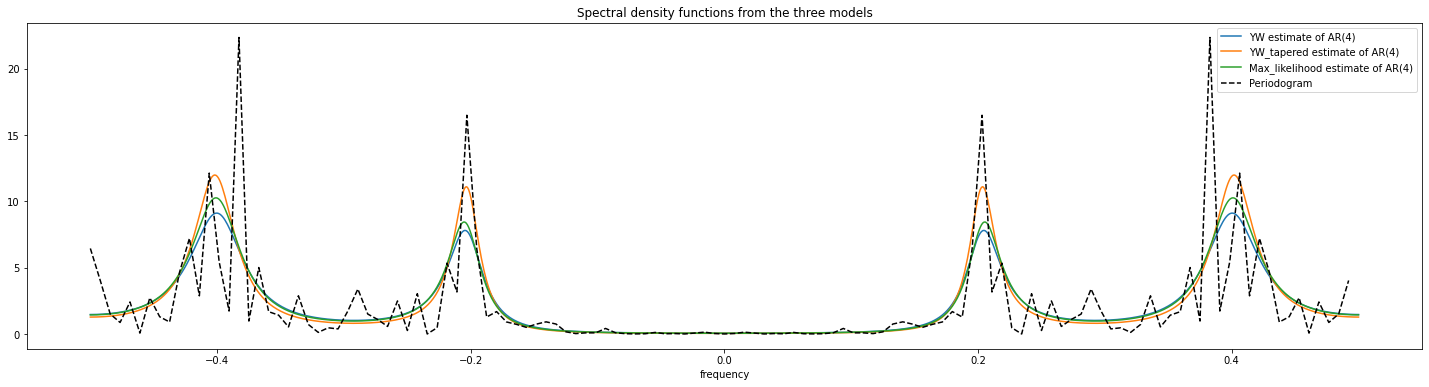

In [241]:
f = np.arange(-N/2, N/2)/N  # shifter Fourier frequencies
t = np.linspace(-1/2, 1/2, 1000)  
p = 4

plt.figure(figsize=(25, 6))

# plot the three estimated sdfs using S_ARMA
plt.plot(t, S_ARMA(t, YW(data, p)[0], [], YW(data, p)[1]), label = f"YW estimate of AR({p})")
plt.plot(t, S_ARMA(t, YW_tapered(data, p)[0], [], YW_tapered(data, p)[1]), label = f"YW_tapered estimate of AR({p})")
plt.plot(t, S_ARMA(t, max_likelihood(data, p)[0], [], max_likelihood(data, p)[1]), label = f"Max_likelihood estimate of AR({p})")
plt.plot(f, fftshift(periodogram(data)), "k--", label = "Periodogram")  # we also plot the periodogram for reference
plt.title("Spectral density functions from the three models")
plt.xlabel("frequency")
plt.legend()
plt.show()

Question 3

(a)

First we determine the parameter $p$ of the $AR$ by using a similar method as before - we compute the AIC for different $p$.

In [185]:
observed_data = data[0:118]

# store the AIC values here
max_likelihood_AIC = []

# compute the AIC for each p and each model
for p in np.arange(1,21):
    max_likelihood_AIC.append(AIC(p, len(observed_data), max_likelihood(observed_data, p)[1]))

# create table
header = ["p", "Maximum Likelihood"]
table = [ [i+1, max_likelihood_AIC[i]] for i in range(20)]

df = pd.DataFrame(table, columns = header)
df.style.hide_index()

p,Maximum Likelihood
1,78.584249
2,67.365125
3,52.736695
4,2.199065
5,4.382445
6,6.849402
7,4.589437
8,6.222231
9,3.991863
10,5.826467


Once again the lowest value is for $p$ is $4$, so we fit the model on the observed data using max likelihood method for $AR(4)$.

In [205]:
p = 4
observed_data = data[0:118]
phis, sigma2 = max_likelihood(observed_data, p)

predicted_data = observed_data[-p:]
for i in range(10):
    predicted_data.append(np.dot(phis, np.flip(predicted_data[-p:])))
# use the last 11 data points so that the prediction is connected to observed data on the plots
predicted_data = predicted_data[-11:] 

# calculate the absolute difference between the predicted values and the true data
absolute_diff = abs(np.array(data[-12: -1]) - np.array(predicted_data))

# create table
header = ["True trajectory", "Predicted trajectory", "Absolute difference"]
table = [data[-11:], predicted_data, absolute_diff]

df = pd.DataFrame(np.column_stack(table), columns = header)
df.style.hide_index()

True trajectory,Predicted trajectory,Absolute difference
-1.623100,-1.623100,2.320280
-1.700000,-0.893680,0.729420
1.869400,0.889270,2.589270
-0.755030,0.820677,1.048723
1.167000,0.202858,0.957888
-0.058720,-1.030713,2.197713
-0.874310,-0.447165,0.388445
-0.137570,0.618415,1.492725
0.341240,0.517236,0.654806
-1.104900,-0.007743,0.348983


We have created a table to compare the predicted data with the true trajectory. We hav also included the absolute difference between the two, to see more clearly how much we have deviated. We can see that our predictions are not very similar to the true data points (although there are some similarities). This is because of the randomness in the nature of the model.

(b)

First, we create a function that will simulate the next 10 steps of an $AR(p)$ model given a certain observed data. We then create $999$ simulations and use them to construct a $90%$ prediction interval which we plot together with the true and predicted trajectories.

In [206]:
def AR(X, p, phis, sigma2):
    """Simulate an AR(p) process of length 10 given observed data."""
    
    for i in range(10):
        X.append(np.dot(phis, np.flip(X[-p:])) + np.random.normal(0,np.sqrt(sigma2)))

    return X[-10:]

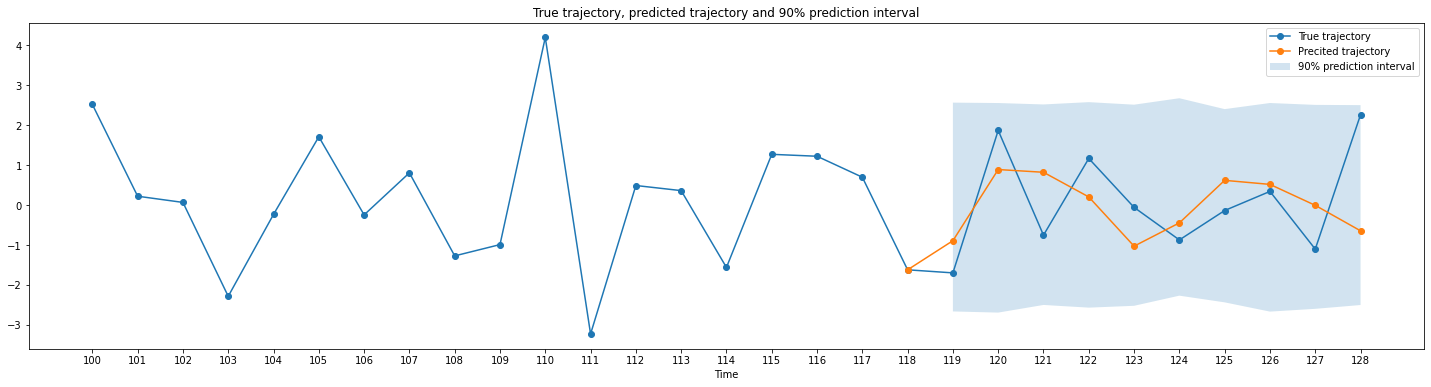

In [239]:
p = 4
observed_data = data[0:118]
phis, sigma2 = max_likelihood(observed_data, p)

# create a matrix where each row contains the simulated data points from the 999 simulation for a single time (10 time points in total)
a = np.empty(shape = (10, 999))

for i in range(999):
    simulated_data = AR(observed_data, p, phis, sigma2)
    for j in range(10):
        a[j][i] = simulated_data[j]

# compute the lower and upper bound trajectories
lower_bounds = []
upper_bounds = []

for i in range(10):
    a[i].sort()
    lower_bounds.append(a[i][49])
    upper_bounds.append(a[i][949])


# plot the true trajectory, the predicted trajectory and the 90% prediction interval
t = np.linspace(100,128, 29)
plt.figure(figsize=(25, 6))
plt.plot(t, data[99:128], label = "True trajectory", marker="o")
plt.plot(t[-11:], predicted_data, label = "Precited trajectory", marker="o")
plt.fill_between(t[-10:], lower_bounds, upper_bounds, alpha = 0.2, label = "90% prediction interval")
plt.title("True trajectory, predicted trajectory and 90% prediction interval")
plt.xlabel("Time")
plt.xticks(t)
plt.legend()
plt.show()